
This script is used to train a network to map the imagery activation patterns onto the capsule space. This network is beforehand trained on the perception data, one trial of each letter is excluded for validation. This script also gives the option to select 100 most relevant voxel and then use these for training and testing the network.
Eventually, the activation patterns at capsule layer are compared to the expected activation patterns.

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from tensorflow import keras
from keras import *
import tensorflow as tf

After the relevant imports, the drive needs to be mounted to the folder where the files of the fMRI data are lying.

In [2]:
%load_ext tensorboard
import datetime
from google.colab import drive
import os

drive.mount('/content/drive')
%cd '/content/drive/My Drive/CapsNets'
#log_dir = "/content/drive/My Drive/CapsNets/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#os.makedirs(log_dir, exist_ok=True)
#%tensorboard --port=6008 --logdir {log_dir}

Mounted at /content/drive
/content/drive/My Drive/CapsNets


Import the file for average activations during perception.

In [3]:
path_to_file = '/content/drive/MyDrive/CapsNets/fMRI Data/Higher visual areas/Activations_PerceptionAverageBoth.txt'
#'CapsNets/fMRI Data/Higher visual areas/Activation_PerceptionAverage.txt'

with open(path_to_file) as f:
    lines = [line.rstrip() for line in f]

print(lines[24:])

H_perc_av = []
T_perc_av = []
S_perc_av = []
C_perc_av = []

#HTSC
for line in lines[24:]:
  x = line.split()
  H_perc_av.append(float(x[3]))
  T_perc_av.append(float(x[5]))
  S_perc_av.append(float(x[7]))
  C_perc_av.append(float(x[9]))

print(len(H_perc_av))

['152 262 217     3.373113   0.000918    0.648295   0.517657    2.564566   0.011185    3.038172   0.002751', '152 264 218     2.824305   0.005298    0.591667   0.554851    3.059961   0.002569    2.399586   0.017482', '152 265 218     2.898530   0.004238    2.077634   0.039229    2.902307   0.004189    1.567467   0.118843', '152 262 219     4.062737   0.000074    1.502528   0.134795    2.665343   0.008424    4.234015   0.000037', '152 263 219     3.826591   0.000182    1.925648   0.055798    3.044622   0.002696    5.105129  8.6948e-07', '152 262 220     6.329013  2.0698e-09    2.686584   0.007927    3.947673   0.000115    4.876579   0.000002', '152 263 220     5.837999  2.5731e-08    2.669543   0.008323    4.622863   0.000007    5.649052  6.5636e-08', '152 264 220     2.866436   0.004670   -0.089834   0.928530    2.422909   0.016434    3.649767   0.000348', '152 269 220     3.245190   0.001411    1.351539   0.178297    4.211835   0.000041    1.658187   0.099102', '152 270 220     2.1609

Import the file for single trial activations during perception. Each letter has eight representations, which means there are eight values in each voxel line per letter. 

In [4]:
path_to_file = '/content/drive/MyDrive/CapsNets/fMRI Data/Higher visual areas/Activation_PerceptionRun_TrialsBoth.txt'


with open(path_to_file) as f:
    lines = [line.rstrip() for line in f]

num_vox = len(lines[24:])

H_perc_trials = np.zeros((8, num_vox))
T_perc_trials = np.zeros((8,num_vox))
S_perc_trials = np.zeros((8, num_vox))
C_perc_trials = np.zeros((8,num_vox))

#HTSC, each voxel one list item in list
for line in range(24, 24 + len(lines[24:])):
  x = lines[line].split()
  index = 0
  for trial in range(3,18,2):
      H_perc_trials[index,line -24] = float(x[trial])
      index += 1
  index = 0
  for trial in range(19,34,2):
      T_perc_trials[index, line -24] = float(x[trial])
      index += 1
  index = 0
  for trial in range(35,50,2):
      S_perc_trials[index, line -24] = float(x[trial])
      index += 1
  index = 0
  for trial in range(51, 66, 2):
      C_perc_trials[index, line - 24] = float(x[trial])
      index += 1


  #H_perc_trials.append([float(x[3]), float(x[5]), float(x[7]), float(x[9]), float(x[11]), float(x[13]), float(x[15]), float(x[17])])
  #T_perc_trials.append([float(x[19]), float(x[21]), float(x[23]), float(x[25]), float(x[27]), float(x[29]), float(x[31]), float(x[33])])
  #S_perc_trials.append([float(x[35]), float(x[37]), float(x[39]), float(x[41]), float(x[43]), float(x[45]), float(x[47]), float(x[49])])
  #C_perc_trials.append([float(x[51]), float(x[53]), float(x[55]), float(x[57]), float(x[59]), float(x[61]), float(x[63]), float(x[65])])

print(C_perc_trials)

[[ 2.217942  1.957903  1.233957 ...  1.03406   1.081095  0.781943]
 [ 1.393828  1.353353  0.220718 ...  2.871393  1.474929  0.915371]
 [ 2.047303  1.083287  1.695634 ...  2.405432  3.88749   2.992287]
 ...
 [ 1.123564  1.328816  1.274571 ...  2.083228  2.274327  0.607764]
 [ 0.432843  0.718018 -0.516436 ...  1.561068  1.534592 -0.293173]
 [ 1.39097   2.265247  1.762294 ...  2.86442   3.065317  0.598953]]


Now each trial for imagery needs to be read.

In [5]:
path_run1 = '/content/drive/MyDrive/CapsNets/fMRI Data/Higher visual areas/Activations_ImageryRun1Both.txt'
path_run2 = '/content/drive/MyDrive/CapsNets/fMRI Data/Higher visual areas/Activations_ImageryRun2Both.txt'
path_run3 = '/content/drive/MyDrive/CapsNets/fMRI Data/Higher visual areas/Activation_ImageryRun3Both.txt'
path_run4 = '/content/drive/MyDrive/CapsNets/fMRI Data/Higher visual areas/Activation_ImageryRun4Both.txt'

all_pathes = [path_run1, path_run2, path_run3, path_run4]
with open(path_run1) as f:
    lines = [line.rstrip() for line in f]
    num_vox = len(lines[24:])

H_im_trials = np.zeros((len(all_pathes) * 8, num_vox))
T_im_trials = np.zeros((len(all_pathes) * 8, num_vox))
S_im_trials = np.zeros((len(all_pathes) * 8, num_vox))
C_im_trials = np.zeros((len(all_pathes) * 8, num_vox))

for path in range(len(all_pathes)):
  with open(all_pathes[path]) as f:
    lines = [line.rstrip() for line in f]

  num_vox = len(lines[24:])
  #figure out how to incorporate all runs and not just one here
  for line in range(24, 24 + len(lines[24:])):
    x = lines[line].split()
    index = 0
    for trial in range(3,18,2):
      H_im_trials[index + path*8, line - 24] = float(x[trial])
      index += 1
    index = 0
    for trial in range(19,34,2):
      T_im_trials[index + path*8, line - 24] = float(x[trial])
      index += 1
    index = 0
    for trial in range(35,50,2):
      S_im_trials[index +path*8, line - 24] = float(x[trial])
      index += 1
    index = 0
    for trial in range(51, 66, 2):
      C_im_trials[index +path*8, line - 24] = float(x[trial])
      index += 1

In [6]:
print(C_im_trials)
C_im_trials.shape

[[-1.42773  -1.79591   0.636475 ...  0.726961  0.336622 -1.243882]
 [ 1.672196 -0.892733 -0.042934 ...  0.957568  1.467405  2.865506]
 [ 1.091852  0.522789 -0.359033 ...  2.787856  1.791369  1.725348]
 ...
 [ 0.882514  0.791608  0.390781 ...  2.337665  0.033449  0.039753]
 [ 1.01446  -1.527322 -1.964037 ... -0.354076 -1.567065  0.756469]
 [ 0.478056  1.106045  0.648168 ... -0.197997  0.055113 -1.207419]]


(32, 734)

# Read in the Capsule Activation patterns for each letter

For this part of the code, it is necessary to run the model and send each letter stimulus once through it. Then the activations of the "digit capsules" are going to be reflective of what the CapsNet would predict for each of them.

In [22]:
caps2_output = np.loadtxt('Caps2_output.txt')

In [23]:
caps_h = []
caps_s = []
caps_c = []
caps_t = []

order_in_caps = 'chst'

for line in caps2_output[0:4]:
  #x = line.split()
  x = line
  globals()[f'caps_{order_in_caps[0]}'].append([float(item) for item in x])
for line in caps2_output[4:8]:
  #x = line.split()
  x=line
  globals()[f'caps_{order_in_caps[1]}'].append([float(item) for item in x])
for line in caps2_output[8:12]:
  #x = line.split()
  x=line
  globals()[f'caps_{order_in_caps[2]}'].append([float(item) for item in x])
for line in caps2_output[12:]:
  #x = line.split()
  x=line
  globals()[f'caps_{order_in_caps[3]}'].append([float(item) for item in x])
  #caps_h.append([float(item) for item in x])

In [24]:
print(caps_c)

[[0.10178332775831223, 0.06923104077577591, -0.1681206375360489, -0.14410506188869476, 0.19548438489437103, -0.2447669506072998, -0.26540279388427734, 0.4496418535709381, -0.055534813553094864, 0.2740517854690552, 0.32286688685417175, -0.1903320997953415, 0.029286978766322136, 0.20627069473266602, -0.0607728511095047, -0.24346353113651276], [0.01481835637241602, 0.008403857238590717, -0.021063052117824554, 0.00507618160918355, 0.033483028411865234, 0.011543415486812592, -0.014929666183888912, -0.012161461636424065, 0.008465217426419258, -0.006360823288559914, -0.03147580474615097, 0.004982845392078161, -0.009800435043871403, 0.024045448750257492, 0.042879052460193634, 0.005138254724442959], [-0.013232960365712643, 0.02529270201921463, -0.0446334108710289, 0.016905909404158592, 0.02028219774365425, -0.016086190938949585, -0.004949770402163267, -0.028384901583194733, -0.016428735107183456, -0.026090657338500023, -0.003171644639223814, -0.010789048857986927, -0.03578878939151764, -0.02629

Prepare the data to run through the network - 7 trials used as training, one trial used as validation trial.

In [25]:
x_train = np.concatenate((C_perc_trials[:7], H_perc_trials[:7], S_perc_trials[:7], T_perc_trials[:7]), axis=0)
#x_train = np.concatenate((X_selected[0:7], X_selected[8:15], X_selected[16:23], X_selected[24:31]),axis =0)
#x_train = ([C_perc_trials, H_perc_av_trials, S_perc_av_trials, T_perc_av_trials])
x_test =  np.concatenate((C_perc_trials[7:], H_perc_trials[7:], S_perc_trials[7:], T_perc_trials[7:]), axis=0)
#x_test = np.stack((X_selected[range(7,32,8)]),axis = 0)

#y_train = np.array([[y for x in caps_c_short for y in (x if isinstance(x, list) else [x])], [y for x in caps_h_short for y in (x if isinstance(x, list) else [x])], [y for x in caps_s_short for y in (x if isinstance(x, list) else [x])], [y for x in caps_t_short for y in (x if isinstance(x, list) else [x])]])
y_train = np.array([[y for x in caps_c for y in (x if isinstance(x, list) else [x])], [y for x in caps_h for y in (x if isinstance(x, list) else [x])], [y for x in caps_s for y in (x if isinstance(x, list) else [x])], [y for x in caps_t for y in (x if isinstance(x, list) else [x])]])
y_train = np.array([item for item in y_train for i in range(7)])
#y_test = np.array([[y for x in caps_c_short for y in (x if isinstance(x, list) else [x])], [y for x in caps_h_short for y in (x if isinstance(x, list) else [x])], [y for x in caps_s_short for y in (x if isinstance(x, list) else [x])], [y for x in caps_t_short for y in (x if isinstance(x, list) else [x])]])
y_test = np.array([[y for x in caps_c for y in (x if isinstance(x, list) else [x])], [y for x in caps_h for y in (x if isinstance(x, list) else [x])], [y for x in caps_s for y in (x if isinstance(x, list) else [x])], [y for x in caps_t for y in (x if isinstance(x, list) else [x])]])
#x_train

Prepare data in the relevant form for the imagery trials - so that they can be fed through the neural net for reconstructions.

In [26]:
x_test_im = np.concatenate((C_im_trials, H_im_trials, S_im_trials, T_im_trials), axis=0)
#y_test_im = np.array([[y for x in caps_c_short for y in (x if isinstance(x, list) else [x])], [y for x in caps_h_short for y in (x if isinstance(x, list) else [x])], [y for x in caps_s_short for y in (x if isinstance(x, list) else [x])], [y for x in caps_t_short for y in (x if isinstance(x, list) else [x])]])
y_test_im = np.array([[y for x in caps_c for y in (x if isinstance(x, list) else [x])], [y for x in caps_h for y in (x if isinstance(x, list) else [x])], [y for x in caps_s for y in (x if isinstance(x, list) else [x])], [y for x in caps_t for y in (x if isinstance(x, list) else [x])]])
y_test_im = np.array([item for item in y_test_im for i in range(32)])

Let's build an easy model that maps voxel activations to the different activations in the Capsule layer. For training of this network, the trial-wise data of perception is used. One of the eight trials of each category is used to validate the estimation. Afterwards, the whole network is tested on the imagery data.

In [27]:
tf.keras.backend.clear_session()

In [28]:
def squash(s, axis=-1, epsilon=1e-9, name=None):
    with tf.name_scope(name):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

Different sizes and numbers of layers were tried out to find the best-fitting network.

In [29]:
inputs = keras.Input(shape=(734,), name="voxels")
#x = layers.Dense(512, activation="relu", name="dense_1")(inputs)
#x = layers.Dense(600, activation="relu", name="dense_2")(x)
x = layers.Dense(256, activation="relu", name="dense_3")(inputs)
x = layers.Dense(128, activation="relu", name="dense_4")(x)
x = layers.Dense(64, name = "dense_last")(x)
outputs = squash(x, name = "predictions")

#outputs = layers.Dense(64, name = "predictions")(x)
#model.add(layers.Dense(800, activation="relu", name="layer1"))
#model.add(layers.Dense(400, activation="relu", name="layer2"))
#model.add(layers.Dense(128, activation="relu", name="layer3"))
#model.add(layers.Dense(64, name="layer4"))
model = keras.Model(inputs=inputs, outputs=outputs)

This network would be the same structure in case the feature reduction is applied.

In [30]:
#inputs = keras.Input(shape=(100,), name="voxels")
#x = layers.Dense(512, activation="relu", name="dense_1")(inputs)
#x = layers.Dense(600, activation="relu", name="dense_2")(x)
#x = layers.Dense(256, activation="relu", name="dense_3")(inputs)
#x = layers.Dense(128, activation="relu", name="dense_4")(x)
#outputs = layers.Dense(64, name = "dense_last")(x)
#outputs = squash(x, name = "predictions")
#outputs = layers.Dense(4, name = "predictions")(x)
#model.add(layers.Dense(800, activation="relu", name="layer1"))
#model.add(layers.Dense(400, activation="relu", name="layer2"))
#model.add(layers.Dense(128, activation="relu", name="layer3"))
#model.add(layers.Dense(64, name="layer4"))
#model = keras.Model(inputs=inputs, outputs=outputs)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 voxels (InputLayer)            [(None, 734)]        0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          188160      ['voxels[0][0]']                 
                                                                                                  
 dense_4 (Dense)                (None, 128)          32896       ['dense_3[0][0]']                
                                                                                                  
 dense_last (Dense)             (None, 64)           8256        ['dense_4[0][0]']                
                                                                                              

In [32]:
model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.MeanSquaredError())

Let's train the network.

In [33]:
history = model.fit(
    x_train,
    y_train,
    batch_size=4,
    epochs=5,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(np.array(x_test), y_test),
)

Epoch 1/5
7/7 [==============================] - 1s 31ms/step - loss: 0.0195 - val_loss: 0.0149
Epoch 2/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0139 - val_loss: 0.0141
Epoch 3/5
7/7 [==============================] - 0s 7ms/step - loss: 0.0127 - val_loss: 0.0139
Epoch 4/5
7/7 [==============================] - 0s 7ms/step - loss: 0.0118 - val_loss: 0.0139
Epoch 5/5
7/7 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0141


Now we can test the network.

In [34]:
y_pred = model.predict(x_test) #replace x_test  with x_test_selected to use the 100 voxel selection as data
model.evaluate(x_test,  y_test, verbose=2)
#print(y_pred)

1/1 - 0s - loss: 0.0141 - 110ms/epoch - 110ms/step


0.014073990285396576

These predictions are safed to a file in our working directory now.

In [35]:
np.savetxt('fMRI_Caps2_pred.txt', y_pred)

The predictions for the imagery data area also calculated.

In [36]:
model.evaluate(x_test_im,  y_test_im, verbose=2)
y_pred_im = model.predict(x_test_im)

#model.evaluate(X_im_selected, y_test_im, verbose = 2) # use these lines to do the same thing for the 100 selected voxels
#y_pred_im = model.predict(X_im_selected)

4/4 - 0s - loss: 0.0167 - 26ms/epoch - 6ms/step


Now we can also save the capsule predictions for imagery trials - these than can be run through the decoder of the model to make reconstructions from these.

In [37]:
np.savetxt('fMRI_im_Caps2_pred.txt', y_pred_im)

# Reduction to 100 features

If reduction to 100 featuers would be wanted, that would be a way to get there.

In [38]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from yellowbrick.model_selection import feature_importances
from sklearn import preprocessing

The training data is fit with logistic regression. The 100 most important voxels are selected.

Data with initial features
        0         1         2         3         4         5         6    \
0  1.108806  0.786042  0.067354  1.465789 -0.527087  1.036611  0.003707   
1  0.275692  0.217911 -0.758635 -0.046606  0.966155 -0.516135  0.225494   
2  0.936304 -0.035886  0.443712 -0.086845  0.554703  0.661328 -0.120340   
3 -0.243567 -1.604011 -1.377637  1.575367  0.458875  0.212756  1.007026   
4  0.380277 -0.073116  0.018124 -0.472307  1.080053 -1.041287 -0.334014   

        7         8         9    ...       724       725       726       727  \
0  0.025821  0.287045  0.418559  ...  0.300793 -1.895447 -1.820295 -1.443540   
1  0.544408 -0.386890  0.589992  ...  0.300777  0.090564  0.545306  0.314557   
2  0.797894 -0.167257 -0.203605  ...  0.195810  1.148584  0.905820  1.362431   
3  0.777911 -0.856610 -0.907202  ... -0.355303  0.132827 -1.501264 -0.778538   
4  0.344852 -1.271277 -0.172261  ...  0.585413  0.763312  0.608448  0.405991   

        728       729       730       731

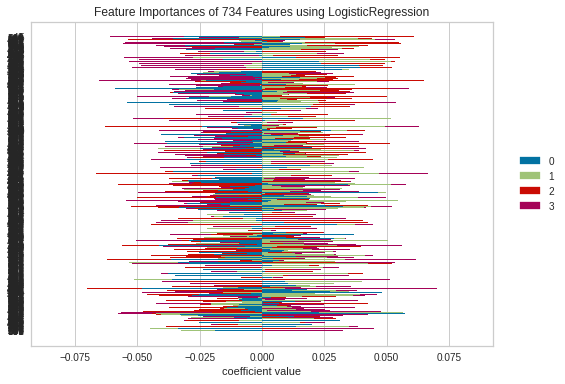

FeatureImportances(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f5442ff0dd0>,
                   estimator=LogisticRegression(max_iter=500), relative=False,
                   stack=True)


In [39]:
y = np.array([item for item in [0,1,2,3] for i in range(7)])

scaler = preprocessing.StandardScaler().fit(x_train)
X_scaled = scaler.transform(x_train)

estimator = LogisticRegression(max_iter=500)
selector = RFE(estimator, n_features_to_select=100, step=1)
selector.fit(X_scaled, y)
X_selected = selector.transform(X_scaled)

print('Data with initial features')
print(pd.DataFrame(X_scaled).head())
print()
print('Data with selected features')
print(pd.DataFrame(X_selected).head())
print()
print(feature_importances(estimator, X_scaled, y, stack=True,relative=False))

These selected voxels can then also be applied to the test and test imagery data set.

In [40]:
#scaler = preprocessing.StandardScaler().fit(x_test_im)
#X_scaled_im = scaler.transform(x_test_im)
X_im_selected = selector.transform(x_test_im)
x_test_selected = selector.transform(x_test)

# Analysis of the predictions

In [41]:
!pip install researchpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
from PIL import ImageChops, Image
import math, operator
from matplotlib import pyplot
from skimage.metrics import structural_similarity as ssim
import cv2
import argparse
from astropy.table import QTable
from numpy import *
from scipy.spatial.distance import pdist, squareform
import pandas as pd
#from pandas import *
import researchpy as rp
import scipy.stats as stats
import os
import sys

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [43]:
#dcov, dvar,cent_dist_dcor to calculate distance correlation between two matrices https://en.wikipedia.org/wiki/Distance_correlation
def dcov(X, Y):
    #Computes the distance covariance between matrices X and Y.
    n = X.shape[0]
    XY = np.multiply(X, Y)
    cov = np.sqrt(XY.sum()) / n
    return cov

def dvar(X):
    #Computes the distance variance of a matrix X
    return np.sqrt(np.sum(X ** 2 / X.shape[0] ** 2))

def cent_dist(X):
    #Computes the pairwise euclidean distance between rows of X and centers
    #each cell of the distance matrix with row mean, column mean, and grand mean
    M = squareform(pdist(X))    # distance matrix
    rmean = M.mean(axis=1)
    cmean = M.mean(axis=0)
    gmean = rmean.mean()
    R = np.tile(rmean, (M.shape[0], 1)).transpose()
    C = np.tile(cmean, (M.shape[1], 1))
    G = np.tile(gmean, M.shape)
    CM = M - R - C + G
    return CM

def dcor(X, Y):
    #Computes the distance correlation between two matrices X and Y.
    #X and Y must have the same number of rows.
    #>>> X = np.matrix('1;2;3;4;5')
    #>>> Y = np.matrix('1;2;9;4;4')
    #>>> dcor(X, Y)
    #0.76267624241686649
    assert X.shape[0] == Y.shape[0]
    A = cent_dist(X)
    B = cent_dist(Y)
    dcov_AB = dcov(A, B)
    dvar_A = dvar(A)
    dvar_B = dvar(B)
    dcor = 0.0
    if dvar_A > 0.0 and dvar_B > 0.0:
        dcor = dcov_AB / np.sqrt(dvar_A * dvar_B)
    return dcor

In [44]:
y_pred_im.shape
y_test.shape

(4, 64)

Now, the correlations between the expected activation patterns at capsule layer and the apparent activation levels are calculated.

In [48]:
correlation = np.zeros((len(y_pred_im), len(y_test)))
counter = 0
for item in range(len(y_pred_im)):
  for letter in range(len(y_test)):
    correlation[item][letter] = dcor(y_pred_im[item].reshape(4,16), y_test[letter].reshape(4,16))
  if item < 32 and np.argmax(correlation[item]) == 0:
    counter += 1
  elif 32 <= item < 32*2 and np.argmax(correlation[item]) == 1:
    counter += 1
  elif 32*2 <= item < 32*3 and np.argmax(correlation[item]) == 2:
    counter += 1
  elif 32*3 <= item and np.argmax(correlation[item]) == 3:
    counter += 1
  else:
    print(item, (correlation[item]))
print(f"{counter}/{len(y_pred_im)} == {counter/len(y_pred_im)} highest correlation with the according stimulus")  

5 [0.82310957 0.80583541 0.86134266 0.73914473]
7 [0.82765431 0.78912869 0.85870918 0.77616178]
16 [0.79999423 0.75343479 0.8795928  0.81874441]
19 [0.82189841 0.78108997 0.81326725 0.83811592]
26 [0.81069351 0.77442226 0.85577264 0.79389843]
27 [0.83265541 0.84550647 0.8108966  0.72404317]
30 [0.79587473 0.81914022 0.87651023 0.76560063]
31 [0.77686283 0.82204376 0.86174878 0.7973005 ]
32 [0.81717698 0.78187656 0.84279627 0.81243915]
33 [0.82304495 0.77575754 0.8584714  0.78728696]
34 [0.8843454  0.8135892  0.80164107 0.73257519]
35 [0.86754075 0.78006827 0.82174768 0.76451029]
36 [0.83178553 0.79584741 0.86063209 0.76332238]
37 [0.84307319 0.8345563  0.8169454  0.75612445]
38 [0.84769593 0.76734976 0.83927099 0.80291988]
39 [0.89951499 0.72332075 0.78858446 0.78742378]
40 [0.85351831 0.7588492  0.8678499  0.76045156]
41 [0.87504708 0.77834938 0.83016177 0.75200628]
42 [0.87012716 0.78233715 0.85355697 0.72702294]
43 [0.8220534  0.75270103 0.87446649 0.80311151]
44 [0.8836761  0.73286

See how many trials are assigned highest likelihood for the correct letter at capsule layer. This assignment is random.

In [49]:
true_vs_predict = np.zeros((128,2))
index = 0
c_likelihood = np.zeros((len(y_pred_im),2))
h_likelihood = np.zeros((len(y_pred_im),2))
s_likelihood = np.zeros((len(y_pred_im),2))
t_likelihood = np.zeros((len(y_pred_im),2))
for item in range(len(y_pred_im)):
    #read single imagery trial and see what likelihoods are assigned to each letter
    imagery = y_pred_im[item].reshape([4,16])
    c_likelihood = imagery[0][0]
    h_likelihood = imagery[1][0]
    s_likelihood = imagery[2][0]
    t_likelihood = imagery[3][0]
    #take the position of the letter that was assigned the maximum likelihood
    min_pos = np.argmax((c_likelihood, h_likelihood, s_likelihood, t_likelihood))
    print(max((c_likelihood, h_likelihood, s_likelihood, t_likelihood)))
    if item < 32:
      true_vs_predict[item][0] = 0
    elif 32 <= item < 64:
      true_vs_predict[item][0] = 1
    elif 64 <= item < 97:
      true_vs_predict[item][0] = 2
    elif 97 <= item:
      true_vs_predict[item][0] = 3
    true_vs_predict[item][1] = min_pos
    #compare whether highest likelihood is assigned to the letter that is supposed to have highest likelihood
    if true_vs_predict[item][0] == true_vs_predict[item][1]:
      index = index + 1

print(f"{index}/{len(y_pred_im)} correctly classified at the capsule layer for imagery trials")
print(index/len(y_pred_im))

-0.06014646
0.1864932
0.18455145
0.215908
0.21698909
0.2549469
0.25480708
0.26278606
0.09027733
0.1698787
0.25643927
0.19884615
0.13767946
0.016372394
0.2201511
0.1251565
-0.052946687
0.16593587
0.031139182
0.12739964
0.18422309
0.20569402
0.05385565
0.1309326
-0.018231038
0.03597405
0.24458444
0.1309078
0.14409849
0.10346241
0.18649083
-0.01840284
0.24195404
0.192718
0.22759776
0.19033426
0.2457962
0.17120999
0.23370796
0.08564721
0.08560171
0.17496099
0.18551786
0.055104613
0.16349687
0.11311026
0.009938111
0.14112398
0.04182832
0.1668271
0.11389535
0.25665557
0.2117217
0.26464996
0.19901767
0.20448029
0.112180434
0.0851802
0.16823225
0.11902261
0.13607006
0.1170698
0.12422433
0.21286541
0.18143943
0.20870543
0.20188864
0.14440656
0.249125
0.19371784
0.21699508
0.21102591
0.22667646
0.12573269
0.08972842
0.052448377
0.22164099
0.25008327
0.29908955
0.18422242
0.21388151
0.16182642
0.1157927
0.18728569
0.088403486
0.05903412
0.24531049
0.0688672
0.19265163
0.15642256
0.16538368
-0.062